In [ ]:
# General Includes
import json
import os
import random
import subprocess
import time
from datetime import datetime
from pathlib import Path

from IPython.display import clear_output, display
from tqdm import tqdm

In [ ]:
def shell(cmd, debug=False, returns_POpen=False, close_fds=False):
    if debug:
        print(cmd)

    if returns_POpen:
        process = subprocess.Popen(cmd, close_fds=close_fds)
        return process

    process = subprocess.run(cmd, stdout=subprocess.PIPE)
    return process.stdout.decode("utf-8").strip().splitlines()


def adb(cmd, debug=False, returns_POpen=False, close_fds=False):
    # This function runs adb commands on your connected device or emulator.
    if type(cmd) == str:
        cmd = cmd.split(" ")
    cmd = ["adb"] + cmd
    return shell(cmd, debug=debug, returns_POpen=returns_POpen, close_fds=close_fds)


adb("wait-for-device")

In [ ]:
def FindColor(im, color, tolerence):

    s = time.time()
    min_r = color[0] - tolerence
    min_g = color[1] - tolerence
    min_b = color[2] - tolerence

    max_r = color[0] + tolerence
    max_g = color[1] + tolerence
    max_b = color[2] + tolerence

    for x in range(1, im.width - 1, 2):
        for y in range(1, im.height - 1, 2):
            rgb = im.getpixel((x, y))
            if (
                rgb[0] > min_r
                and rgb[0] < max_r
                and rgb[1] > min_g
                and rgb[1] < max_g
                and rgb[2] > min_b
                and rgb[2] < max_b
            ):
                yield (x, y)

    print("Find Color took ", time.time() - s)

In [ ]:
from PIL import Image, ImageDraw


def pullImage(resize_ratio=None):
    s = time.time()
    adb("shell screencap -p /sdcard/screen.png")
    adb("pull /sdcard/screen.png ./game.png")
    adb("shell rm /sdcard/screen.png")
    im = Image.open("game.png")
    im = im.convert("RGB")
    if resize_ratio is not None:
        im = im.resize(
            (int(im.width * resize_ratio), int(im.height * resize_ratio)),
            Image.Resampling.LANCZOS,
        )
    print("pull image took ", time.time() - s)
    return im

In [ ]:
def getCenter(points, area_range=5):
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    center = (
        int(sum(x) / len(points)) + random.randint(0 - area_range, area_range),
        int(sum(y) / len(points)) + random.randint(0 - area_range, area_range),
    )
    return center

In [ ]:
last_click = time.time()
resize_ratio = 0.25
can_click = True

In [ ]:
# theifing
silk = (173, 133, 153)
silk_t = 10

pie = (228, 208, 122)
pie_t = 10

furs = (177, 136, 3)
furs_t = 45

cabbage = (169, 201, 73)
cabbage_t = 35

master_farmer = (64, 80, 53)
master_farmer_t = 2

tomato = (153, 0, 0)
tomato_t = 50

In [ ]:
# hunting
bird_trap = (196, 91, 58)
bird_trap_t = 15

In [ ]:
def basicClick(center):
    adb(f"shell input tap {center[0]} {center[1]}")

In [ ]:
color = tomato
threshold = tomato_t
action = basicClick

In [ ]:
class Mass:
    def __init__(self, locs, start_x, start_y, search_distance=3):

        self.locs = locs
        self.start_x = start_x
        self.start_y = start_y
        self.toSearch = []
        self.search_distance = search_distance
        self.points = []
        self.addRelated((start_x, start_y))
        self.processCells()

    def addRelated(self, point):
        for i in range(0, self.search_distance):
            self.toSearch.append((point[0] + i, point[1]))
            self.toSearch.append((point[0] - i, point[1]))
            self.toSearch.append((point[0], point[1] + i))
            self.toSearch.append((point[0], point[1] - i))
            self.toSearch.append((point[0] - i, point[1] - i))
            self.toSearch.append((point[0] + i, point[1] - i))
            self.toSearch.append((point[0] - i, point[1] + i))
            self.toSearch.append((point[0] + i, point[1] + i))

    def processCells(self):
        while len(self.toSearch) > 0:
            i = self.toSearch.pop()
            if i in self.locs:
                self.addRelated(i)
                self.points.append(i)
                self.locs.remove(i)

    def __repr__(self):
        return f" {len(self.points)}"

    def __gt__(self, other):
        return len(self.points) > len(other.points)


def split_into_seperate_objects(l):
    masses = []
    while len(l) > 0:
        seed = l.pop()
        mass = Mass(l, seed[0], seed[1])
        if len(mass.points) < 10:
            continue
        print("mass contains", len(mass.points), "points")
        for item in mass.points:
            if item in l:
                l.remove(item)
        masses.append(mass)
    return masses


def getLargestMass(l):
    a = split_into_seperate_objects(l)
    m = max(a)
    return m

In [87]:
a = pullImage()
draw = ImageDraw.Draw(a)
found_pix_list = list(FindColor(a, color, threshold))

print("started finding largest mass", len(found_pix_list))
result = split_into_seperate_objects(found_pix_list)
print("finished finding largest mass")
print(result)

pull image took  0.59967041015625
Find Color took  0.385483980178833
started finding largest mass 8647
mass contains 59 points
mass contains 36 points
mass contains 2433 points
mass contains 12 points
mass contains 2494 points
mass contains 69 points
mass contains 13 points
mass contains 1255 points
mass contains 837 points
mass contains 811 points
mass contains 168 points
mass contains 34 points
mass contains 281 points
finished finding largest mass
[ 59,  36,  2433,  12,  2494,  69,  13,  1255,  837,  811,  168,  34,  281]


ZeroDivisionError: division by zero

[]


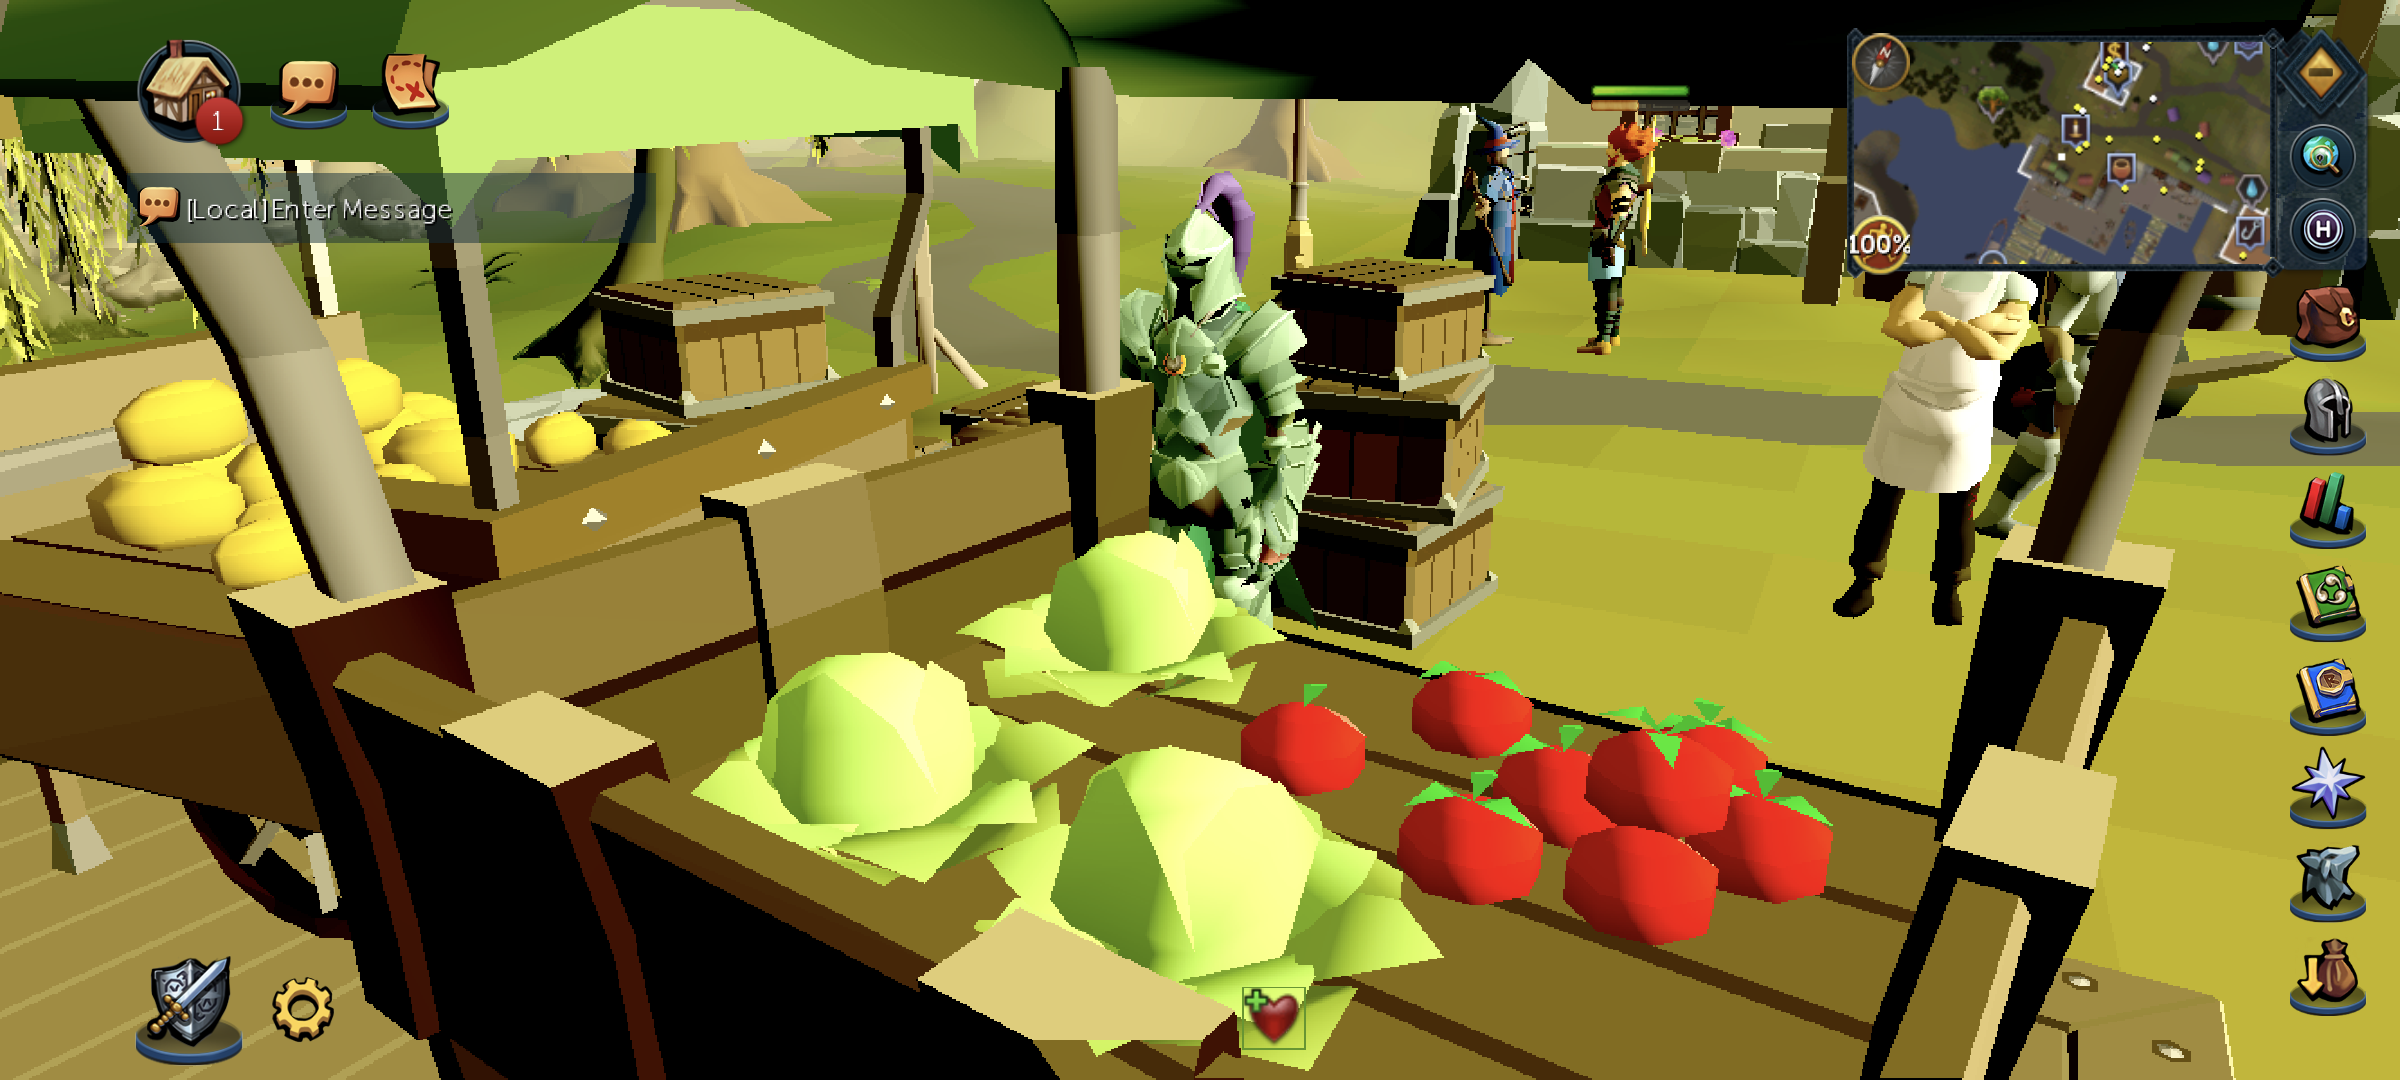

In [88]:
center = getCenter(found_pix_list)
print(center)
print(found_pix_list)
if len(found_pix_list) > 2:
    for p in found_pix_list:
        a.putpixel(p, (255, 0, 255))

    draw.ellipse(
        (center[0] - 10, center[1] - 10, center[0] + 10, center[1] + 10),
        fill=(12, 137, 0),
        outline=(255, 255, 255),
    )
display(a)

(1582, 844)


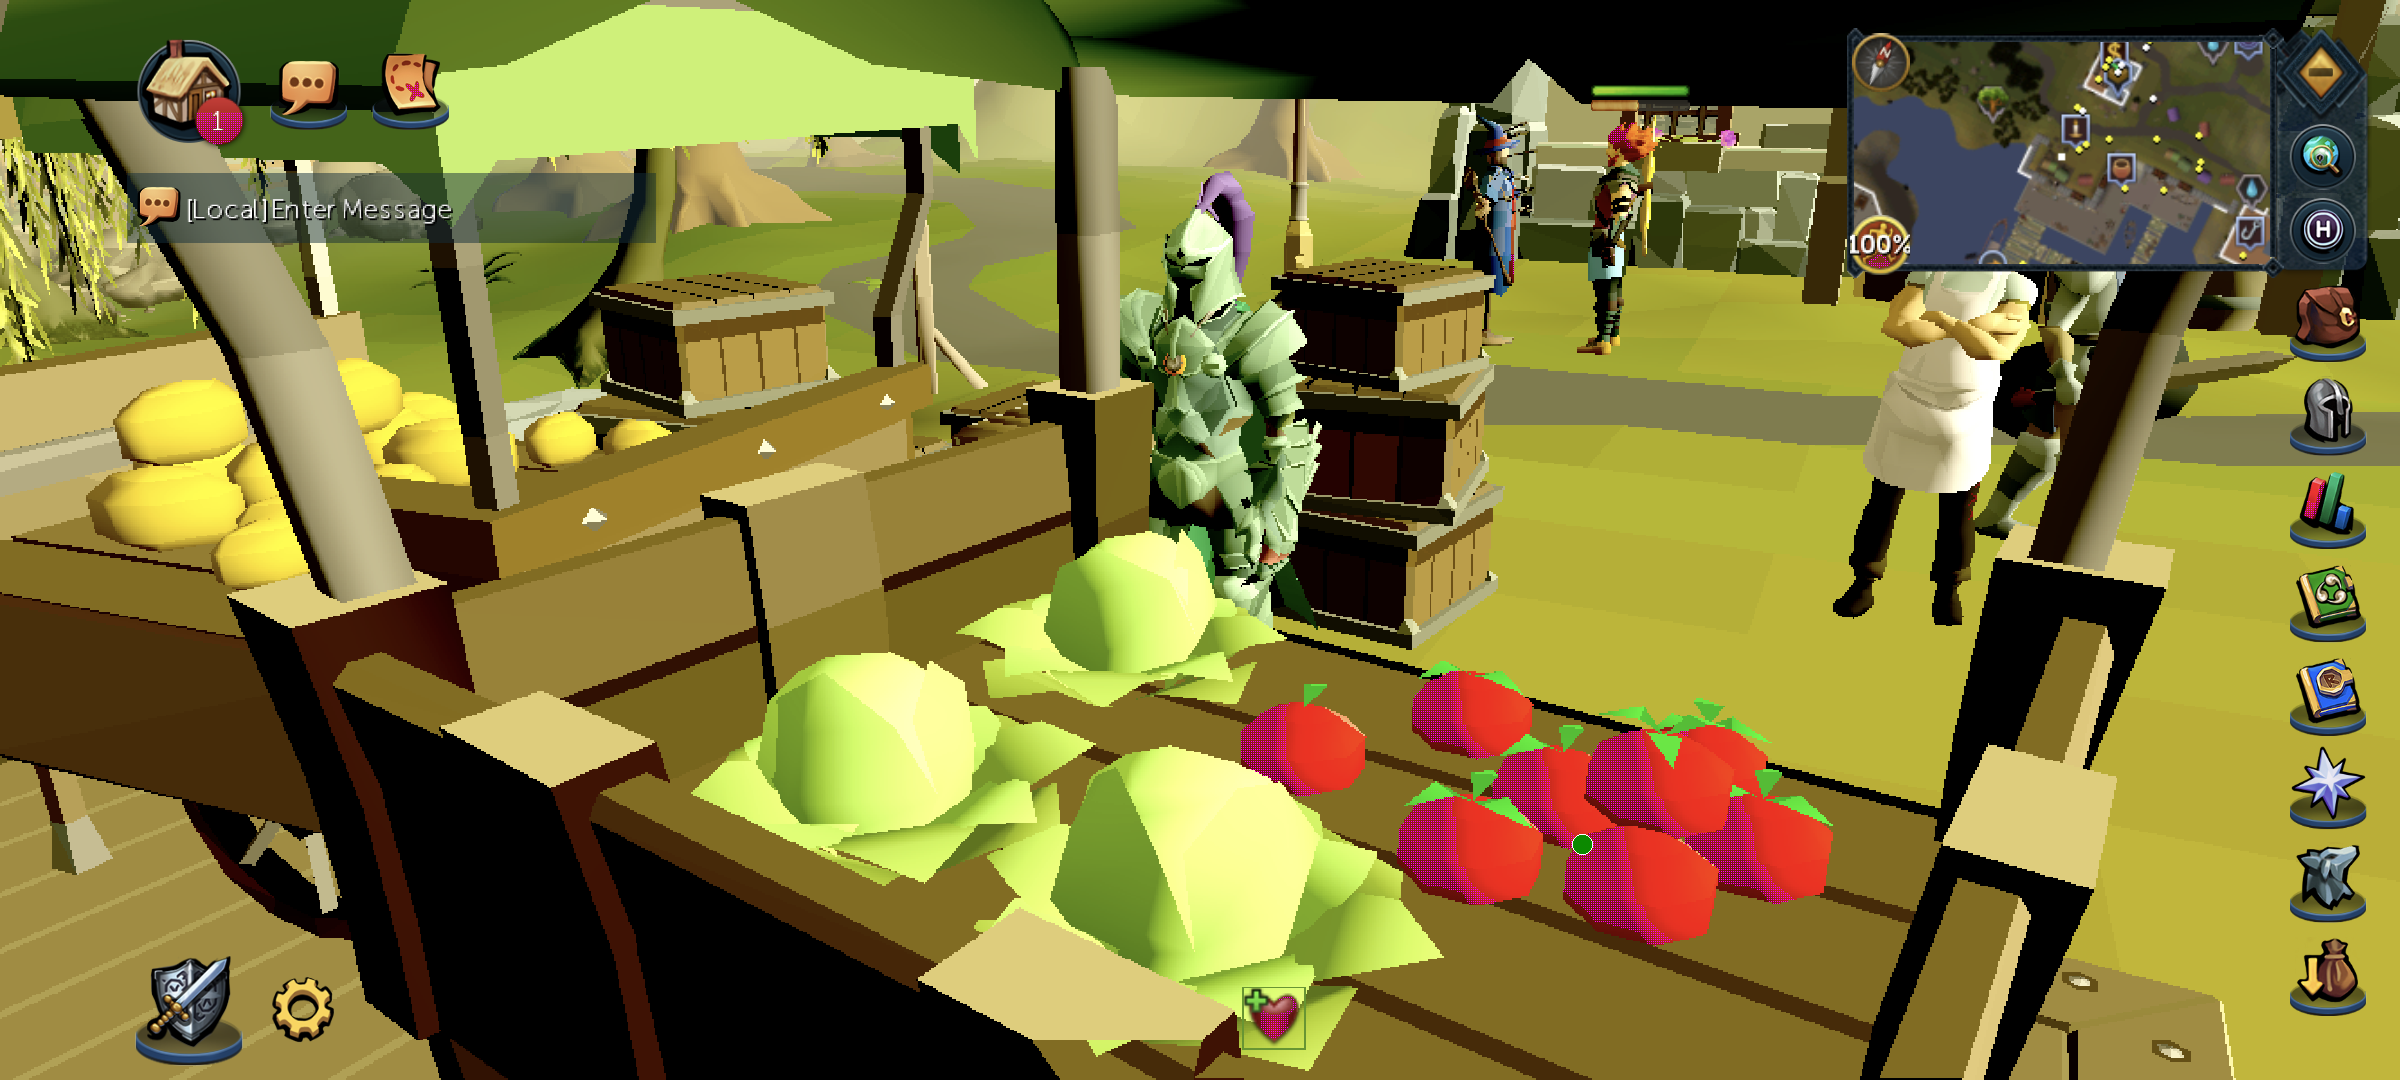

In [90]:
if len(result) > 0:
    center = getCenter(max(result).points)
    print(center)
    for loc in result:
        for p in loc.points:
            a.putpixel(p, (255, 0, 255))

    draw.ellipse(
        (center[0] - 10, center[1] - 10, center[0] + 10, center[1] + 10),
        fill=(12, 137, 0),
        outline=(255, 255, 255),
    )
display(a)

In [94]:
runs = 40
min_delay = 3
click_throttle = 5
random_delay = [2.5, 3, 2, 1]
if click_throttle < min(random_delay) + min_delay:
    print("Your setup has a min delay that is too short")
while runs > 0:
    runs -= 1
    a = pullImage()
    found_pix_list = list(FindColor(a, color, threshold))
    center = getCenter(found_pix_list)
    if time.time() - last_click > click_throttle:
        last_click = time.time()
        #       draw.ellipse((center[0]-10,center[1]-10,center[0]+10,center[1]+10), fill=(255, 0, 0), outline=(255, 255, 255))
        print(runs, center, datetime.now())
        if can_click:
            action(center)
            time.sleep(random.choice(random_delay))

    # display(a)
    # print('sleep')
    time.sleep(min_delay)
    print()

pull image took  0.7158095836639404
Find Color took  0.4070258140563965
(1351, 709) (1581, 851)
39 (1351, 709) 2022-08-07 15:51:22.435105

pull image took  0.730302095413208
Find Color took  0.4142892360687256
(1336, 740) (1581, 851)
38 (1336, 740) 2022-08-07 15:51:29.146896

pull image took  0.7971668243408203
Find Color took  0.41048359870910645
(1336, 728) (1581, 851)
37 (1336, 728) 2022-08-07 15:51:36.442198

pull image took  0.7900311946868896
Find Color took  0.44117021560668945
(1330, 722) (1581, 851)
36 (1330, 722) 2022-08-07 15:51:42.714924

pull image took  0.6788747310638428
Find Color took  0.38939499855041504
(1334, 740) (1581, 851)
35 (1334, 740) 2022-08-07 15:51:48.870541

pull image took  0.764885425567627
Find Color took  0.40346312522888184
(1334, 735) (1581, 851)
34 (1334, 735) 2022-08-07 15:51:55.623949

pull image took  0.6933069229125977
Find Color took  0.3927938938140869
(1292, 719) (1581, 851)
33 (1292, 719) 2022-08-07 15:52:01.802990

pull image took  0.788927